# General information 

Wave energy is a rapidly advancing and promising renewable energy source that holds great potential for addressing the challenges of global warming and climate change. However, optimizing energy output in large wave farms presents a complex problem due to the expensive calculations required to account for hydrodynamic interactions between wave energy converters (WECs). Developing a fast and accurate surrogate model is crucial to overcome these challenges. In light of this, we have compiled an extensive WEC dataset that includes 54,000 and 9,600 configurations involving 49 and 100 WECs, coordination, power, q-factor, and total farm power output. The dataset was derived from a study published at the GECCO conference and received the prestigious Best Paper award. We want to acknowledge the support of the University of Adelaide Phoenix HPC service in conducting this research. For more details, please refer to the following link: https://dl.acm.org/doi/abs/10.1145/3377930.3390235.

## Features
The dataset includes 4 CSV files for 49 and 100 wave energy converters based on Perth and Sydney wave scenarios. The main goal is predicting the total power output of the wave farm based on the coordination of WECs (X1, Y1, X2, Y2,..., Xn, Yn). As the second plan, predicting the power output of each converter in the wave farm can be interesting. 

* X and Y - coordinates
* Power - individual power
* total power - total power of all the WECs
* qW - q-factor 

## Findings
There are many duplicates in the dataset (4540).

## Goal
* Predicting the total power output of the wave farm based on the coordination of WECs
* Predicting the power ouput of each converter in the wave farm

## Candidates for inaccuracy
* To small dataset -> need more data
* Not the right regression model -> Test many different regression models and measure their accuracy

## Potential Problems
* Cannot inference based on geodata from only 4 locations, especially with a relatively small dataset. 
* In what timeframe was the data collected? Becuase you cannot predict the total power over the year if it is also dependent of the seasons
* Why are there so many duplicates? 

## Instances
Each instance represents the coordination of wave energy converters in a wave farm plus the total power output and individual power of each converter and q-factor. 

## Source
https://archive.ics.uci.edu/dataset/882/large-scale+wave+energy+farm
Neshat, Mehdi, Bradley Alexander, Nataliia Y. Sergiienko, and Markus Wagner. "Optimisation of large wave farms using a multi-strategy evolutionary framework." In Proceedings of the 2020 Genetic and Evolutionary Computation Conference, pp. 1150-1158. 2020.
Link to research: https://dl.acm.org/doi/abs/10.1145/3377930.3390235.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [15]:
perth100_data = pd.read_csv("./wave_energy_farm/datasets/WEC_Perth_100.csv")
perth49_data = pd.read_csv("./wave_energy_farm/datasets/WEC_Perth_49.csv")
sydney100_data = pd.read_csv("./wave_energy_farm/datasets/WEC_Sydney_100.csv")
sydney49_data = pd.read_csv("./wave_energy_farm/datasets/WEC_Sydney_49.csv")

In [16]:
dataset = perth100_data.copy(deep=True)

## Preprocessing

In [4]:
dataset.shape

(7277, 302)

In [5]:
dataset.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power93,Power94,Power95,Power96,Power97,Power98,Power99,Power100,qW,Total_Power
0,1000.0,0.0,946.08,37.42,889.67,74.76,832.02,112.10,1250.0,1.0,...,98711.68,102872.82,100743.44,99259.87,98909.46,101388.37,101025.35,98676.66,0.75,7257985.04
1,800.0,0.0,746.04,37.38,689.81,74.79,632.43,111.97,1200.0,0.0,...,96351.38,102253.02,101744.20,99482.45,99304.59,101953.23,100878.42,99508.49,0.74,7103374.61
2,600.0,0.0,545.98,37.50,489.87,74.95,432.52,112.15,650.0,0.0,...,96985.29,102472.80,101757.63,99429.45,98709.14,101312.44,100979.86,99024.16,0.76,7335380.64
3,600.0,0.0,546.09,37.41,489.70,74.76,432.35,111.90,800.0,0.0,...,76823.85,88005.41,98779.92,100260.30,98744.25,101144.58,100835.43,98915.38,0.75,7187769.87
4,600.0,0.0,545.95,37.52,489.69,74.99,432.46,112.16,800.0,0.0,...,98195.95,102874.16,100256.15,99221.12,98969.54,101389.77,100924.02,98796.00,0.75,7260222.61


### Remove Duplicates

In [6]:
dataset = dataset.drop_duplicates()

In [7]:
dataset.shape

(2737, 302)

### Check for null values

In [9]:
#Check how many null values are in the entire dataset
dataset.isnull().sum().sum()

0

## Analysis

In [12]:
columns = list(perth100_data)


### Check for outliers

In [13]:
dataset.describe()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power93,Power94,Power95,Power96,Power97,Power98,Power99,Power100,qW,Total_Power
count,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.00000,2737.000000,...,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2737.000000,2.737000e+03
mean,352.430815,28.443796,376.587603,48.513548,390.824538,67.395784,382.368316,100.883800,748.81297,31.299488,...,88784.392488,94574.215331,97805.710833,97620.391436,97511.043405,98655.269839,98920.618290,97713.614468,0.721995,6.959157e+06
std,293.777257,97.276123,271.069835,59.577117,282.745074,45.932165,299.046854,57.995795,285.37046,73.050856,...,10396.969817,7717.499315,6250.371796,5975.969268,5045.909333,6408.359410,4689.778147,3966.695051,0.020921,1.998767e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,34236.100000,32447.850000,30658.290000,35208.350000,29411.690000,36525.750000,42148.330000,33879.920000,0.630000,6.099480e+06
25%,129.200000,0.000000,146.150000,37.390000,89.980000,65.990000,32.640000,98.430000,600.00000,0.000000,...,76698.160000,87986.780000,98477.180000,98429.200000,98614.520000,98350.170000,98118.470000,96904.240000,0.710000,6.806309e+06
50%,200.000000,0.000000,316.740000,37.490000,324.570000,74.880000,432.240000,112.070000,661.08000,0.000000,...,95014.870000,97237.470000,98785.020000,99601.280000,98840.130000,101312.440000,100905.720000,98796.000000,0.720000,6.941249e+06
75%,600.000000,0.000000,546.040000,37.550000,489.820000,75.010000,514.460000,112.240000,1000.00000,40.990000,...,98339.870000,102029.820000,101089.720000,100267.940000,99017.440000,101438.470000,101027.360000,98959.650000,0.740000,7.129514e+06
max,1400.000000,1353.550000,1400.000000,1277.640000,1414.000000,698.010000,1400.000000,1035.090000,1413.39000,910.420000,...,103541.860000,104047.690000,104403.690000,104206.780000,103678.570000,102543.340000,102219.050000,101692.770000,0.760000,7.364528e+06


In [14]:
dataset["Total_Power"].describe()

count    2.737000e+03
mean     6.959157e+06
std      1.998767e+05
min      6.099480e+06
25%      6.806309e+06
50%      6.941249e+06
75%      7.129514e+06
max      7.364528e+06
Name: Total_Power, dtype: float64

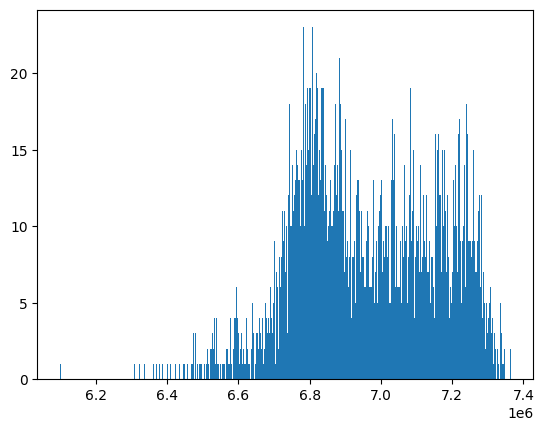

In [15]:
graph = plt.hist(x = dataset["Total_Power"], bins=500)

# Train models to predict Total_Power output of wave energy farms based on coordinates

## Drop the power columns for individual WECs and qW

In [16]:
dataset_copy = dataset.copy(deep=True)

In [17]:
for num in range(1, 101):
    dataset_copy.drop(f"Power{num}", axis=1, inplace=True)

In [18]:
dataset_copy.drop("qW", inplace=True, axis=1)

In [19]:
dataset_copy.shape

(2737, 201)

In [20]:
dataset.shape

(2737, 302)

In [150]:
y = dataset_copy["Total_Power"]
X = dataset_copy.drop("Total_Power", axis=1)

In [151]:
X.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,X96,Y96,X97,Y97,X98,Y98,X99,Y99,X100,Y100
0,1000.0,0.0,946.08,37.42,889.67,74.76,832.02,112.10,1250.0,1.0,...,432.02,1312.10,1200.0,1200.0,1146.08,1237.42,1089.67,1274.76,1032.02,1312.10
1,800.0,0.0,746.04,37.38,689.81,74.79,632.43,111.97,1200.0,0.0,...,232.43,1311.97,800.0,1200.0,746.04,1237.38,689.81,1274.79,632.43,1311.97
2,600.0,0.0,545.98,37.50,489.87,74.95,432.52,112.15,650.0,0.0,...,432.52,1312.15,1000.0,1200.0,945.98,1237.50,889.87,1274.95,832.52,1312.15
3,600.0,0.0,546.09,37.41,489.70,74.76,432.35,111.90,800.0,0.0,...,832.35,1311.90,1200.0,1200.0,1146.09,1237.41,1089.70,1274.76,1032.35,1311.90
4,600.0,0.0,545.95,37.52,489.69,74.99,432.46,112.16,800.0,0.0,...,432.46,1312.16,1200.0,1200.0,1145.95,1237.52,1089.69,1274.99,1032.46,1312.16


## Create train and test set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 ,random_state=42)

## Try Decision Tree Regressor
It is more powerful for nonlinear relationships in data

In [29]:
tree_reg_1 = DecisionTreeRegressor(max_depth=2,random_state=42).fit(X_train, y_train)
tree_reg_2 = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_train)

In [31]:
tree_reg_1.score(X_test, y_test)

0.24867754203147185

In [33]:
tree_reg_2.score(X_test, y_test)

0.44036272433181334

In [34]:
cross_vals = -cross_val_score(tree_reg_1, X,y, scoring="neg_root_mean_squared_error", cv=10)

In [35]:
pd.Series(cross_vals).describe()

count        10.000000
mean     173455.032255
std       11567.575123
min      157648.456309
25%      164704.534676
50%      171671.588416
75%      182107.010265
max      190399.689784
dtype: float64

## Try Random Forest Regressor

In [39]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train).score(X_test,y_test)

0.7169339213180776

In [40]:
cross_vals_forest = cross_val_score(RandomForestRegressor(), X,y,cv=5)
cross_vals_forest

array([0.78259784, 0.74450014, 0.67840646, 0.65533953, 0.64266451])

## Conclusion
Random forest model looks the most promising to predict the total_power

# Train models to predict the power of individual wave energy converters

In [152]:
dataset.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power93,Power94,Power95,Power96,Power97,Power98,Power99,Power100,qW,Total_Power
0,1000.0,0.0,946.08,37.42,889.67,74.76,832.02,112.10,1250.0,1.0,...,98711.68,102872.82,100743.44,99259.87,98909.46,101388.37,101025.35,98676.66,0.75,7257985.04
1,800.0,0.0,746.04,37.38,689.81,74.79,632.43,111.97,1200.0,0.0,...,96351.38,102253.02,101744.20,99482.45,99304.59,101953.23,100878.42,99508.49,0.74,7103374.61
2,600.0,0.0,545.98,37.50,489.87,74.95,432.52,112.15,650.0,0.0,...,96985.29,102472.80,101757.63,99429.45,98709.14,101312.44,100979.86,99024.16,0.76,7335380.64
3,600.0,0.0,546.09,37.41,489.70,74.76,432.35,111.90,800.0,0.0,...,76823.85,88005.41,98779.92,100260.30,98744.25,101144.58,100835.43,98915.38,0.75,7187769.87
4,600.0,0.0,545.95,37.52,489.69,74.99,432.46,112.16,800.0,0.0,...,98195.95,102874.16,100256.15,99221.12,98969.54,101389.77,100924.02,98796.00,0.75,7260222.61


In [153]:
edited_dataset = dataset.copy(deep=True)

In [154]:
edited_dataset.columns

Index(['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5',
       ...
       'Power93', 'Power94', 'Power95', 'Power96', 'Power97', 'Power98',
       'Power99', 'Power100', 'qW', 'Total_Power'],
      dtype='object', length=302)

## Prepare the data

In [155]:
edited_dataset = edited_dataset.drop("Total_Power",axis=1)

In [156]:
edited_dataset.drop("qW", axis=1, inplace=True)

In [157]:
edited_dataset.columns

Index(['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5',
       ...
       'Power91', 'Power92', 'Power93', 'Power94', 'Power95', 'Power96',
       'Power97', 'Power98', 'Power99', 'Power100'],
      dtype='object', length=300)

### Remove duplicates

In [158]:
edited_dataset.drop_duplicates(inplace=True)

In [159]:
edited_dataset.shape

(2737, 300)

In [49]:
len(dataset) -len(edited_dataset)

0

### Transform to individual WECs

In [160]:
def to_individual_WEC(dataset):
    new_dataset = {"X":[], "Y":[], "Power":[]}
    for num in range(0, len(dataset)):
        current_row = dataset.iloc[num]
        for index in range(1,101):
            new_dataset["X"].append(current_row.loc[f"X{index}"])
            new_dataset["Y"].append(current_row.loc[f"Y{index}"])
            new_dataset["Power"].append(current_row.loc[f"Power{index}"])

    new_dataset = pd.DataFrame(new_dataset)
    return new_dataset

In [161]:
new_dataset = to_individual_WEC(edited_dataset)

In [162]:
y = new_dataset["Power"]
X = new_dataset.drop("Power", axis=1)

In [163]:
new_dataset = new_dataset.drop_duplicates()

In [164]:
new_dataset

,X,Y,Power
0,1000.00,0.00,54733.98
1,946.08,37.42,48754.87
2,889.67,74.76,47691.48
3,832.02,112.10,44423.11
4,1250.00,1.00,65183.30
...,...,...,...
273695,432.15,1312.25,99621.37
273696,1400.00,1200.00,98794.13
273697,1346.07,1237.54,101405.41
273698,1289.78,1274.93,100985.18


### Create train and test set

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 ,random_state=42)

### Test with Decision Tree Regressor

In [59]:
dtr = DecisionTreeRegressor(max_depth=5).fit(X_train,y_train)

In [60]:
dtr.score(X_test,y_test)

0.8175329137644313

In [61]:
cvs_dtr = cross_val_score(DecisionTreeRegressor(), X,y,cv=5)

In [62]:
cvs_dtr

array([0.84202991, 0.84541757, 0.84389109, 0.83503579, 0.83833932])

### Test with Random Forest Regressor

In [63]:
rtr = RandomForestRegressor().fit(X_train,y_train)

In [64]:
rtr.score(X_test,y_test)

0.8551296852669787

In [65]:
cvs_rtr = cross_val_score(RandomForestRegressor(), X,y,cv=5)

In [66]:
cvs_rtr

array([0.85443103, 0.85889817, 0.85717885, 0.84873271, 0.85006979])

In [67]:
y_test.head()

229909    45036.45
65271     67483.86
231186    81746.97
4039      45099.45
216022    77271.24
Name: Power, dtype: float64

In [68]:
X_test.head()

,X,Y
229909,346.18,237.50
65271,32.24,1111.84
231186,1289.83,1075.05
4039,232.28,712.28
216022,1289.62,74.98


## Conclusion
And again the random forest model makes the best predictions. And it is more accurate to predict individual WECs than the entire farm.

In [137]:
from matplotlib import cm

In [138]:
plt.style.use('_mpl-gallery')


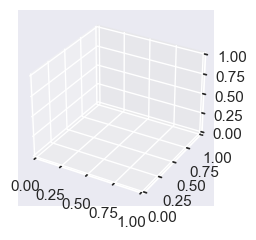

In [139]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

In [140]:
ax.plot_trisurf(new_dataset["X"], new_dataset["Y"], new_dataset["Power"], cmap=cm.Blues)

In [141]:
plt.show()

In [142]:
X,Y,Z = new_dataset["X"], new_dataset["Y"], new_dataset["Power"]

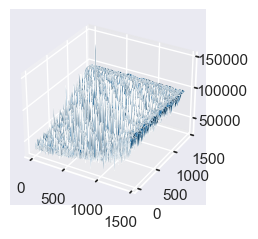

In [146]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

ax.plot_trisurf(x,y,z,vmin=z.min()*2 ,linewidth=0.1)

plt.show()

[(-3.0, 3.0), (-3.0, 3.0)]

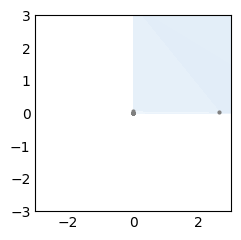

In [86]:
fig, ax = plt.subplots()

ax.plot(x, y, 'o', markersize=2, color='grey')
ax.tripcolor(x, y, z)

ax.set(xlim=(-3, 3), ylim=(-3, 3))


In [87]:
plt.show()

AttributeError: 'function' object has no attribute 'ndim'

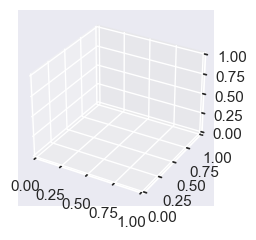

In [144]:
from mpl_toolkits.mplot3d import axes3d

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


ax.plot_surface(X, Y, Z_new, cmap="autumn_r", lw=0, rstride=1, cstride=1)
ax.contour(X, Y, Z_new, 10, lw=3, colors="k", linestyles="solid")
plt.show()

In [105]:
Z

0          54733.98
1          48754.87
2          47691.48
3          44423.11
4          65183.30
            ...    
273695     99621.37
273696     98794.13
273697    101405.41
273698    100985.18
273699     98637.31
Name: Power, Length: 273555, dtype: float64

In [106]:
Z_new = Z.to_numpy

In [107]:
Z_new

<bound method IndexOpsMixin.to_numpy of 0          54733.98
1          48754.87
2          47691.48
3          44423.11
4          65183.30
            ...    
273695     99621.37
273696     98794.13
273697    101405.41
273698    100985.18
273699     98637.31
Name: Power, Length: 273555, dtype: float64>

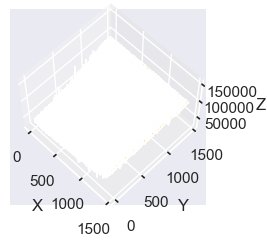

In [145]:
import matplotlib.tri as mtri
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(mtri.Triangulation(X,Y), Z, cmap='jet')
ax.scatter(X,Y,Z, marker='.', s=10, c="black", alpha=.001)
ax.view_init(elev=60, azim=-45)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Trying a deep neural net with tensorflow

In [173]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [174]:
np.set_printoptions(precision=3, suppress=True)


In [178]:
edited_dataset.describe().transpose()[["mean", "std"]]


,mean,std
X1,352.430815,293.777257
Y1,28.443796,97.276123
X2,376.587603,271.069835
Y2,48.513548,59.577117
X3,390.824538,282.745074
...,...,...
Power96,97620.391436,5975.969268
Power97,97511.043405,5045.909333
Power98,98655.269839,6408.359410
Power99,98920.618290,4689.778147


In [184]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [185]:
normalizer.adapt(np.array(X_train))

In [186]:
print(normalizer.mean.numpy())

[[715.068 673.846]]


In [183]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(loss="mean_absolut_error",
             optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [187]:
dnn_wec_model = build_and_compile_model(normalizer)

In [ ]:
%%time
history = dnn_wec_model.fit()